In [189]:
import sys
sys.path.append('..')
import theano.tensor as T
import theano
import numpy
import network_optimizers
import lstm_network_components

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [130]:
# Use scan to do a simple multiplication series

clipper = .1

w = theano.shared(2.)

def set_clipper(val):
    new_val = np.maximum(0.,np.abs(val)).astype(theano.config.floatX)
    clipper.set_value(new_val)

def step( next_x, prev ):
#     return prev * next_x * w
    w_clip = theano.gradient.grad_clip(w,-clipper,clipper)
    return prev * next_x * w_clip

x = T.dvector()

res,_ = theano.scan( fn=step, sequences=x, outputs_info=[np.ones(1)] )

f = theano.function([x],res)

g = T.grad(res[-1].sum(),w)

g_fun = theano.function([x],g)

In [131]:
X = np.array([10,10,10])

print f(X).flatten()
print g_fun(X)

[   20.   400.  8000.]
0.3


In [176]:
def fake_data(n_ex, low_len, high_len, true_iw, true_hw, true_ow):
    
    def fake_data_ex(n_steps,true_iw,true_hw,true_ow):
        n_hidden = true_iw.shape[0]
        inp_size = true_iw.shape[1]
        # the input is just random
        fake_inp = np.random.normal( size=(inp_size,n_steps) )
        # Generate the hidden activation
        h = np.zeros((n_steps+1,n_hidden))
        for i in range(1,n_steps+1):
            h[i,:] = np.tanh(np.dot(true_iw,fake_inp[:,i-1]) + np.dot(true_hw,h[i-1,:].T))
        # Return the input and output
        return fake_inp.T, h[-2:-1,:].T
    
    n_hidden = true_iw.shape[0]
    inp_size = true_iw.shape[1]
    
    seqs = []
    fake_seq_len = []
    outs = []
    
    for i in range(n_ex):
        INP, OUT = fake_data_ex(high_len, true_iw, true_hw, true_ow)
        seqs += [INP]
        fake_seq_len += [np.random.randint(low=low_len, high=high_len)]
        outs += [OUT]
        
    return np.dstack(seqs), fake_seq_len, np.hstack(outs)
    

# Pretty self explanatory
def init_iw(n_hidden,feats): return (np.random.normal(size=(n_hidden,feats))/10   ).astype(theano.config.floatX)
def init_hw(n_hidden,feats): return (np.random.normal(size=(n_hidden,n_hidden))/10).astype(theano.config.floatX)
def init_ow(n_hidden,feats): return (np.random.normal(size=(1,n_hidden))/10       ).astype(theano.config.floatX)



n_hidden = 12
feats = 5

# Set aside some default weights for easy comparison of training methods
# "True" weights for fake data
dflt_iwT = init_iw(n_hidden,feats)
dflt_hwT = init_hw(n_hidden,feats)
dflt_owT = init_ow(n_hidden,feats)

In [177]:
fake_data(3,30,50,dflt_iwT,dflt_hwT,dflt_owT)

(12, 3)

In [139]:
stck = lstm_network_components.LSTM_stack( 5, [(11,12)] )
stck.initialize_stack_weights()

In [191]:
V,L,A = fake_data(10,100,200,dflt_iwT,dflt_hwT,dflt_owT)

In [200]:
stck.layers[0].g_clip = 5

# Input is a 3D stack of sequence represented by a matrix, treated as size = (max_seq_len, n_dim, n_examples)
input_sequence = T.tensor3(name='inp', dtype=theano.config.floatX)

# To fit in a matrix, sequences are zero-padded. So, we need the sequence lengths for each example.
seq_lengths = T.ivector('seq_lengths')

# Target is a onehot encoding of the correct answers for each example, treated as size = (n_options, n_examples)
targets = T.matrix('targets', dtype=theano.config.floatX)

# Through the LSTM stack, then soft max
y, i, f, c, o, h = stck.process(input_sequence, seq_lengths)

cost_sym = T.mean( (targets-y)**2 )

In [201]:
g_fun = theano.function([input_sequence, seq_lengths, targets], T.grad(cost_sym, stck.list_params()))

In [202]:
gs = g_fun( V, L, A )

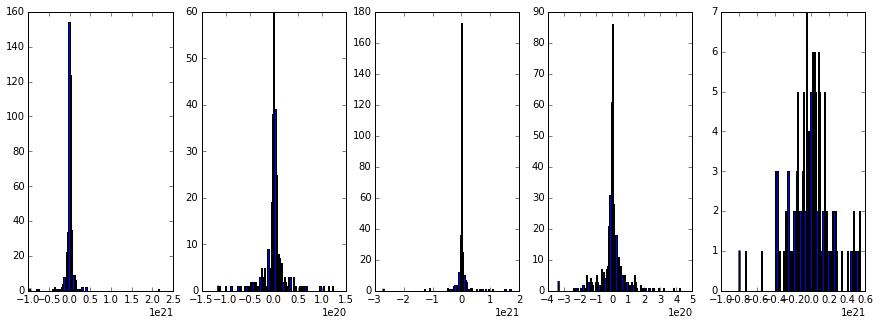

In [199]:
# With clipping at effectively infinite (no clipping)

fig = plt.figure(figsize=(15,5));

ax = fig.add_subplot(1,5,1);
ax.hist(gs[0].flatten(),bins=100);

ax = fig.add_subplot(1,5,2);
ax.hist(gs[2].flatten(),bins=100);

ax = fig.add_subplot(1,5,3);
ax.hist(gs[4].flatten(),bins=100);

ax = fig.add_subplot(1,5,4);
ax.hist(gs[6].flatten(),bins=100);

ax = fig.add_subplot(1,5,5);
ax.hist(gs[8].flatten(),bins=100);

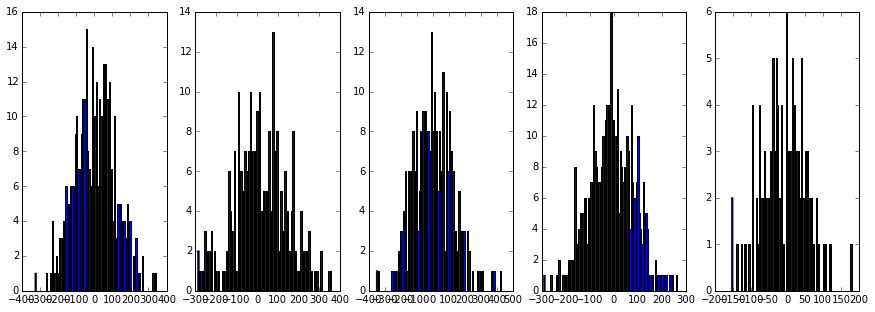

In [203]:
# WIth clipping at 5

fig = plt.figure(figsize=(15,5));

ax = fig.add_subplot(1,5,1);
ax.hist(gs[0].flatten(),bins=100);

ax = fig.add_subplot(1,5,2);
ax.hist(gs[2].flatten(),bins=100);

ax = fig.add_subplot(1,5,3);
ax.hist(gs[4].flatten(),bins=100);

ax = fig.add_subplot(1,5,4);
ax.hist(gs[6].flatten(),bins=100);

ax = fig.add_subplot(1,5,5);
ax.hist(gs[8].flatten(),bins=100);